# Scenario prototype:

Based on the LG Business Requirements defined here: https://docs.google.com/spreadsheets/d/1sTuzO18G9Hr-x1cvJBJfD7ui-CS-Gj9zsjf1Q8X7T0Q/edit#gid=0

# Table of contents:

- ### [1. Generate a scenarion](#Generateascenario)
- ### [2. Set gorwth rate](#setgrowthrate)
- ### [3. Create an intervention](#Createanintervention)
    - #### [3.1 Change the source supplier](#Changethesourcesupplier)
    - #### [3.2 Change the raw material](#Changetherawmaterial)
    - #### [3.3 Change efficiency](#Changeefficiency)
- ### [4. Final notes](#finalNotes)


<a id='Generateascenario'></a>
## 1. Generate a scenario

The user should be able to choose which data of their supplier chain (sourcing record) wants to apply the intervention in order to analyse changes. This data can be filtered by: percentage, material, business unit, supplier and sourcing record.

The user should also be able to select the year of completion of that scenario and type of intervention.

Scenarios ar private by default and owned by their creator

In [69]:
# import libraries
import pandas as pd
from IPython.display import Image
from psycopg2.pool import ThreadedConnectionPool

In [115]:
def project_data(response, default_agr, groupBy, start_year, end_year):
    """
    respose: api response with the format {
        'year',
        'tonnage',
        'impact',
        'indicatorId',
        'indicatorShortName',
        'material_name'
    }
    agr: annual growth rate.
    groupby: same group by as the unse used on the api query

    """
    data = []
    for idx, indicatorId in enumerate(indicators):
        ##append data by indicator
        data.append(
            {
                "indicatorShortName": [el[4] for el in response if el[3] == indicatorId][
                    0
                ],  # set the indicator shortname that we get from the query above
                "indicatorId": indicatorId,  # set the indicator id
                "groupBy": groupBy,  # set the group by key
                "rows": [],  # we will append later the data by year and by group by value
                "yearSum": [],  # we will append later the sum of total impact by yera and by indicator
            }
        )
        # populate rows
        respose_byIndicator = [
            el for el in response if el[3] == indicatorId
        ]  # filter the response by the indicatorId
        unique_names = set(
            [el[5] for el in response if el[3] == indicatorId]
        )  # get unique names for idicator id
        for name in unique_names:
            data[idx]["rows"].append(
                {
                    "name": name,  # set name of the individual names of the groupby key
                    "values": [],  # append values by year
                }
            )
            i = len(data[idx]["rows"]) - 1  # index for appending later the data
            for year in range(
                start_year, end_year + 1
            ):  # iterate over each year from start and end year
                value = [
                    el[2] for el in respose_byIndicator if el[0] == year and el[5] == name
                ]  # get the value of impact for those years we have record on the ddbb
                if len(value):  # if we have data, we append the value
                    data[idx]["rows"][i]["values"].append(
                        {"year": year, "value": value[0], "isProjected": False}
                    )
                    value = value[0]
                else:  # if we don't have data, we project
                    # we get the latest value to project with the default annual growth rate
                    value_to_project = data[idx]["rows"][i]["values"][-1]["value"]
                    value = value_to_project + value_to_project * default_agr / 100
                    data[idx]["rows"][i]["values"].append(
                        {"year": year, "value": value, "isProjected": True}
                    )
        # append the total sum of impact by year by indicator
        for i, year in enumerate(range(start_year, end_year + 1)):
            ## add sum of impact by indicator
            if len(data[idx]["rows"]):
                data[idx]["yearSum"].append(
                    {
                        "year": year,
                        "value": sum(
                            [
                                el["values"][i]["value"]
                                for el in data[idx]["rows"]
                                if el["values"][i]["year"] == year
                            ]
                        ),
                    }
                )
    # ONCE WE HAVE ALL THE DATA BY INDICATOR, THE CLIENT WILL ALSO NEED THE TOTAL PURCHASED VOLUME BY YEAR
    # add total sum of purchase tonnes
    data.append({"name": "purchaseTonnes", "values": []})

    for year in range(start_year, end_year + 1):
        purchase_tonnes = sum([el[2] for el in response if el[0] == year])
        if purchase_tonnes != 0:
            data[-1]["values"].append(
                {"year": year, "value": purchase_tonnes, "isProjected": False}
            )
        else:
            tonnes_to_project = data[-1]["values"][-1]["value"]
            purchase_tonnes = tonnes_to_project + tonnes_to_project * default_agr / 100
            data[-1]["values"].append({"year": year, "value": purchase_tonnes, "isProjected": True})

    return data


## workflow:

## 1. get georegion for new location - geolocate using geolocation estrategy. Output saved on georegion
## 2. get risk for material and each indicator
## 3. get average risk for each indicator in georegion
## 4. calculate impact by multiplying volume time average risk in new location:


def get_LG_base_estimates(material_id, georegion_id):
    LG_base_estimates = {
        "c71eb531-2c8e-40d2-ae49-1049543be4d1": 0,  # carbon_emissions_tCO2e_t
        "633cf928-7c4f-41a3-99c5-e8c1bda0b323": 0,  # deforestation_ha_t
        "0594aba7-70a5-460c-9b58-fc1802d264ea": 0,  # biodiversity_impact_PDF_t
        "e2c00251-fe31-4330-8c38-604535d795dc": 0,  # water_use_m3_t
    }
    # get production tables for materials
    sql_prod_tables = f"""select hd."h3tableName", hd."h3columnName" from h3_data hd where hd.id in (
    select mth."h3DataId" from material_to_h3 mth where mth."materialId" = '{material_id}' and mth."type" ='producer')"""
    cursor.execute(sql_prod_tables)
    response_prodtables = cursor.fetchall()
    prod_table = response_prodtables[0][0]
    prod_column = response_prodtables[0][1]

    ## get harvest tables
    sql_ha_tables = f"""select hd."h3tableName", hd."h3columnName" from h3_data hd where hd.id in (
    select mth."h3DataId" from material_to_h3 mth where mth."materialId" = '{material_id}' and mth."type" ='producer')"""
    cursor.execute(sql_ha_tables)
    response_hatables = cursor.fetchall()
    ha_table = response_hatables[0][0]
    ha_column = response_hatables[0][1]

    ## water indicator factor ####
    # Water risk  (m3 / tones * year) = water footprint (m3/year)/ Total Production (tons)
    sql_wr = f"""select avg(risk.wrisk) from (
        select prodtable.h3index, (indtable."wfBltotMmyr" * 0.001) / sum(prodtable."{prod_column}") over() wrisk from {prod_table} prodtable 
        left join h3_grid_wf_global indTable on indTable.h3index = prodTable.h3index 
        where prodtable."{prod_column}" is not null 
        and indtable."wfBltotMmyr" is not null) risk
        where risk.h3index in (
            select h3_uncompact(gr."h3Compact"::h3index[],6) from geo_region gr where gr.id='{georegion_id}') --new geolocated georegion """

    cursor.execute(sql_wr)
    response_avg_wr = cursor.fetchall()
    LG_base_estimates["e2c00251-fe31-4330-8c38-604535d795dc"] = response_avg_wr[0]

    ## deforestation indicator factor  ####
    # Deforestation risk (ha/tones * year) = deforestation risk (unitless) * Harvested area (ha)/ Total Production (tons)
    sql_dr = f"""select avg(risk.drisk) from (
            select prodtable.h3index, (indtable."hansenLoss2019" * haTable."{ha_column}") / sum(prodtable."{prod_column}") over() drisk from {prod_table} prodtable 
            left join h3_grid_deforestation_global indTable on indTable.h3index = prodTable.h3index 
            left join {ha_table} haTable on haTable.h3index=prodtable.h3index 
            where prodtable."{prod_column}" is not null 
            and indtable."hansenLoss2019" is not null
            and haTable."{ha_column}" is not null) risk
        where risk.h3index in (
            select h3_uncompact(gr."h3Compact"::h3index[],6) from geo_region gr where gr.id='{georegion_id}')"""
    cursor.execute(sql_dr)
    response_avg_dr = cursor.fetchall()
    LG_base_estimates["633cf928-7c4f-41a3-99c5-e8c1bda0b323"] = response_avg_dr[0]

    ## carbon indicator factor ####
    # Carbon risk  (tCO2eq / tones * year ) = carbon risk (tCO2eq / ha) * Deforestation risk (ha/tons)

    sql_cr = f"""select avg(risk.crisk) from (
            select prodtable.h3index, indTable."earthstat2000GlobalHectareEmissions" * ((deftable."hansenLoss2019" * haTable."{ha_column}") / sum(prodtable."{prod_column}") over()) crisk from {prod_table} prodtable 
            left join h3_grid_deforestation_global defTable on defTable.h3index = prodTable.h3index 
            left join {ha_table} haTable on haTable.h3index=prodtable.h3index 
            left join h3_grid_carbon_global indTable on indTable.h3index = prodTable.h3index 
            where prodtable."{prod_column}" is not null 
            and deftable."hansenLoss2019" is not null
            and haTable."{ha_column}" is not null
            and indTable."earthstat2000GlobalHectareEmissions" is not null ) risk
        where risk.h3index in (
            select h3_uncompact(gr."h3Compact"::h3index[],6) from geo_region gr where gr.id='{georegion_id}') """
    cursor.execute(sql_cr)
    response_avg_cr = cursor.fetchall()
    LG_base_estimates["c71eb531-2c8e-40d2-ae49-1049543be4d1"] = response_avg_cr[0]

    ## biodiversity indicator factor ####
    ## biodiversity risk  (PDF / tons * year) =  biodiversity risk ( PDF/year *m2)*(1/0.0001) unit conversion
    sql_br = f"""select avg(risk.crisk) from (
            select prodtable.h3index, indTable."lciaPslRPermanentCrops" * ((deftable."hansenLoss2019" * haTable."{ha_column}") / sum(prodtable."{prod_column}") over()) crisk from {prod_table} prodtable 
            left join h3_grid_deforestation_global defTable on defTable.h3index = prodTable.h3index 
            left join {ha_table} haTable on haTable.h3index=prodtable.h3index 
            left join h3_grid_bio_global indTable on indTable.h3index = prodTable.h3index 
            where prodtable."{prod_column}" is not null 
            and deftable."hansenLoss2019" is not null
            and haTable."{ha_column}" is not null
            and indTable."lciaPslRPermanentCrops" is not null ) risk
        where risk.h3index in (
            select h3_uncompact(gr."h3Compact"::h3index[],6) from geo_region gr where gr.id='{georegion_id}') """
    cursor.execute(sql_br)
    response_avg_br = cursor.fetchall()
    LG_base_estimates["0594aba7-70a5-460c-9b58-fc1802d264ea"] = response_avg_br[0]

    return LG_base_estimates


def calculate_new_impact(estimates, response):
    new_response = [
        (el[0], int(el[1]), int(el[1]) * estimates[el[3]][0], el[3], el[4], el[5])
        for el in response
    ]
    return new_response

In [71]:
# set env
## env file for gcs upload
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value

list(env.keys())

['API_SERVICE_PORT',
 'API_POSTGRES_HOST',
 'API_POSTGRES_PORT',
 'API_POSTGRES_USERNAME',
 'API_POSTGRES_PASSWORD',
 'API_POSTGRES_DATABASE',
 'CLIENT_SERVICE_PORT']

In [72]:
# set conexion to local ddbb
postgres_thread_pool = ThreadedConnectionPool(
    1,
    50,
    host=env["API_POSTGRES_HOST"],
    port=env["API_POSTGRES_PORT"],
    user=env["API_POSTGRES_USERNAME"],
    password=env["API_POSTGRES_PASSWORD"],
)

### 1.1 Define scope:

The first thing the user will need to do is choosing to which data of supply chain they want to apply the intervention in order to analyze changes as is shown in image below:



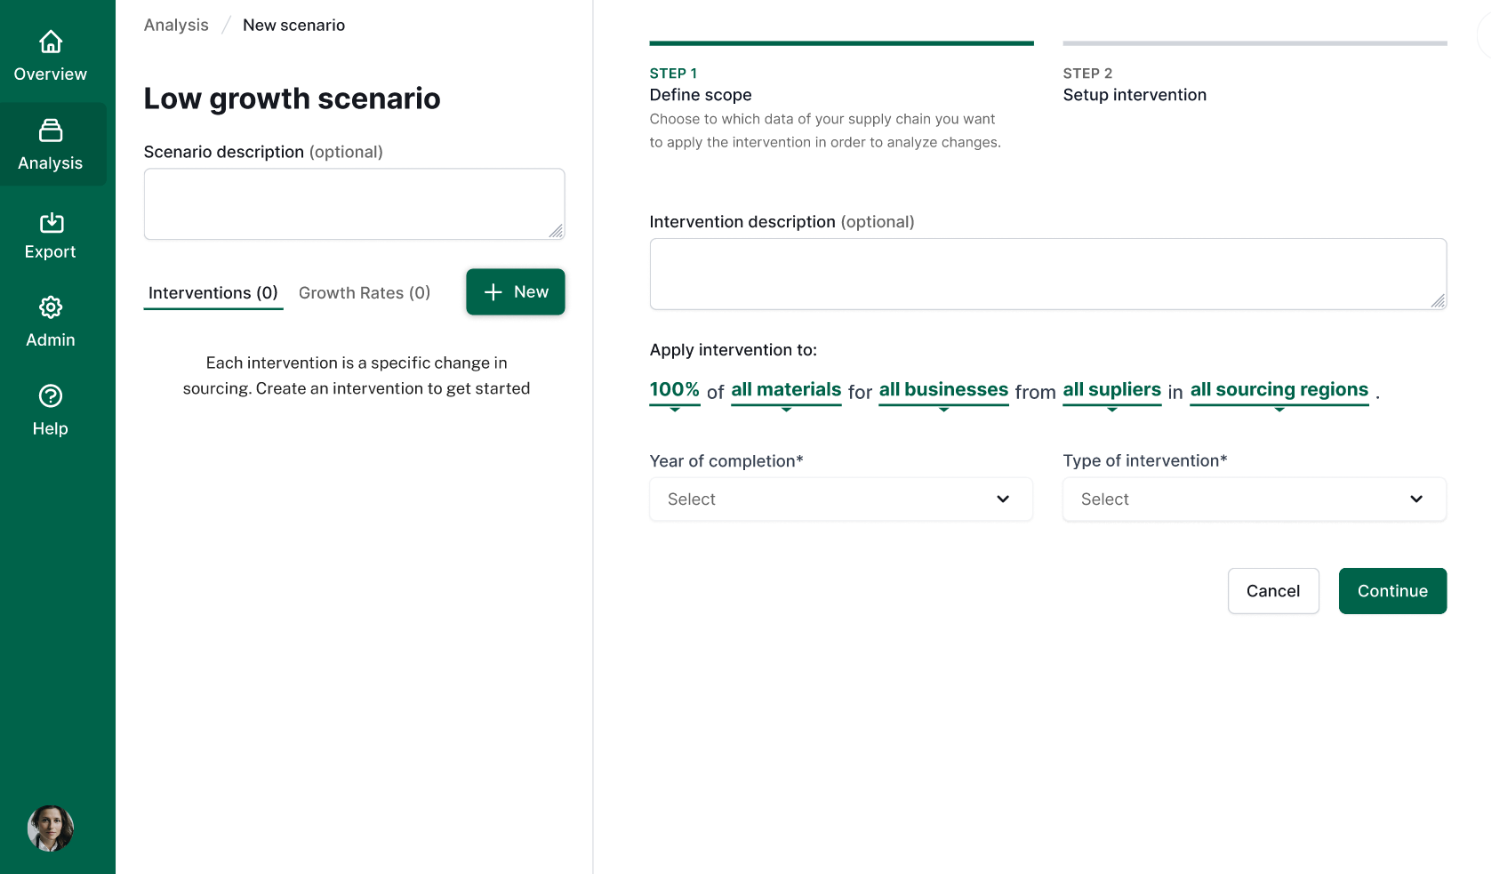

In [73]:
Image(filename="../../datasets/raw/images/scenario_creation.png", width=900, height=300)

To filter the user data the user should be able to select:

- percentage of volume they want to work with (e.g. 100%)
- the materials (e.g. all materials) - the user can select one material or all. If all are selected the % volume would be applied evenly)
- the business units (e.g. all businesses) - one bu or all.
- the suppliers (e.g. all supliers) - one or all.
- the sourcing regions (e.g. all sourcing regions) one or all.



In [74]:
#### PARAMS SELECTED BY THE USER#########
volume_perc = 50
material = ["0d7b1be5-dc86-47b8-ba3a-25190a275011"]  # rubber
business_unit = "all"
suppliers = "all"
sourcing_regions = "7625bf66-dd45-44b8-a15d-8733338660ba"  # indonesia
end_year = 2022
group_by = "material"
start_year = 2019  # note: which start year?
indicators = (
    "0594aba7-70a5-460c-9b58-fc1802d264ea",
    "633cf928-7c4f-41a3-99c5-e8c1bda0b323",
    "c71eb531-2c8e-40d2-ae49-1049543be4d1",
    "e2c00251-fe31-4330-8c38-604535d795dc",
)  # all indicators

In [75]:
# RETRIEVE DATA

sql = f"""SELECT sr."year", sum(sr.tonnage) tonnes, sum(ir.value) impact, i.id, i."shortName", m."name"  FROM sourcing_records sr 
    LEFT JOIN sourcing_location sl ON sl.id=sr."sourcingLocationId" 
    LEFT JOIN indicator_record ir ON ir."sourcingRecordId" = sr.id 
    LEFT JOIN "indicator" i ON i.id =ir."indicatorId" 
    LEFT JOIN material m ON m.id =sl."materialId"
    WHERE sl."materialId" in (
        SELECT m.id FROM material m 
        WHERE m."parentId" IN ('{material[0]}') OR m.id IN ('{material[0]}'))
    --AND sl."businessUnitId" IN (
        --SELECT bu.id FROM business_unit bu 
        --WHERE bu."parentId" =('{business_unit}') OR bu.id =('{business_unit}')
    --)
    --AND sl."t1SupplierId" IN (
        --SELECT s.id FROM supplier s 
        --WHERE "parentId" =('{suppliers}') OR s.id=('{suppliers}'))
    --OR sl."producerId" IN (
        --SELECT s.id FROM supplier s 
        --WHERE "parentId" =('{suppliers}') OR s.id=('{suppliers}'))
    AND sl."adminRegionId" IN (
        SELECT ar.id FROM admin_region ar 
        WHERE ar."parentId" =('{sourcing_regions}') OR ar.id=('{sourcing_regions}'))
    AND sr."year" BETWEEN {start_year} AND {end_year}
    AND i.id in {indicators}
    GROUP BY sl."materialId", sr."year", i.id, i."shortName", m."name" -- add the group by element selected by the client"""

# print(sql)
conn = postgres_thread_pool.getconn()
cursor = conn.cursor()

print("Requestng data..")
cursor.execute(sql)
response = cursor.fetchall()
print("Done!")

Requestng data..
Done!


In [76]:
# distribute volume:
vol_per = (volume_perc / len(material)) / 100
clean_response = [
    (el[0], int(el[1]) * vol_per, int(el[2]) * vol_per, el[3], el[4], el[5]) for el in response
]

In [77]:
df_ = pd.DataFrame(
    clean_response, columns={"year", "tonnes", "impact", "indicatorId", "indicator", "groupby"}
)
df_ = df_.rename(
    columns={
        "indicator": "year",
        "indicatorId": "tonnes",
        "groupby": "impact",
        "year": "indicatorId",
        "impact": "indicator",
        "tonnes": "groupby",
    }
)
df_.head()

,year,tonnes,impact,indicatorId,indicator,groupby
0,2019,1422.0,3005.0,0594aba7-70a5-460c-9b58-fc1802d264ea,biodiversity loss,Rubber and articles thereof
1,2019,1422.0,511.0,633cf928-7c4f-41a3-99c5-e8c1bda0b323,Deforestation loss,Rubber and articles thereof
2,2019,1422.0,6696.5,c71eb531-2c8e-40d2-ae49-1049543be4d1,GHG emissions,Rubber and articles thereof
3,2019,1422.0,3138.0,e2c00251-fe31-4330-8c38-604535d795dc,Unsustainable water use,Rubber and articles thereof
4,2020,1436.0,3034.5,0594aba7-70a5-460c-9b58-fc1802d264ea,biodiversity loss,Rubber and articles thereof


These data should be parsed following the same approach described in the notebook "7_Tables_&_charts_prototype_v1".

The next thing would be to:

    - Set growth rate
    - Select the type of implementation:
        - Change source supplier
        - Raw material
        - efficiency factors

<a id='setgrowthrate'></a>
## 2. Set gorwth rate

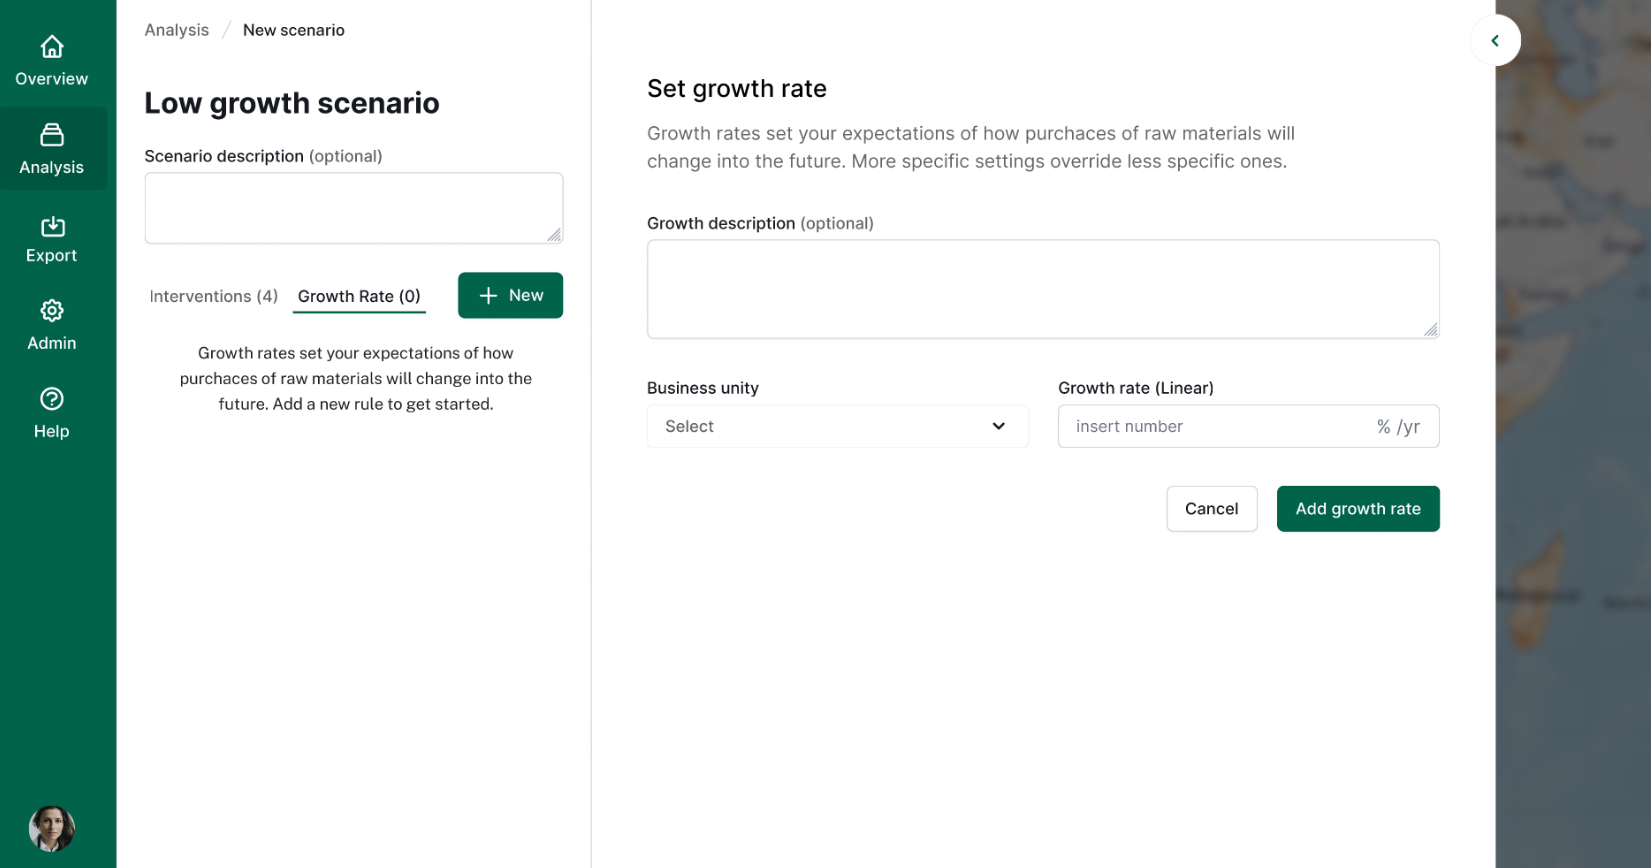

In [78]:
Image(filename="../../datasets/raw/images/set_growth_rate.png", width=900, height=300)

In [116]:
# the growth rate can be set for all business units or for one of the business units ingested by the user
bu_gr = "all"
growth_rate = 1.5  # expectations of how purchase of raw material will change into the future

In [80]:
# parse the data to the structure required by the client
parsed_data = project_data(
    response=clean_response, default_agr=1.5, groupBy="material", start_year=2019, end_year=2022
)

In [81]:
# exacmple for one location
print("indicator", parsed_data[0]["indicatorShortName"])
print("material", parsed_data[0]["rows"][0]["name"])
pd.DataFrame(parsed_data[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,3005.0,3034.5,3080.0175,3126.217762
isProjected,False,False,True,True


<a id='Createanintervention'></a>
## 3. Create an intervention

<a id='Changethesourcesupplier'></a>
### 3.1 Change the source supplier

The user should be able to change from an existing supplier to a new supplier. This would mean the change of the supplier selected in thesept one to the new supplier selected in this intervention. The change can be one to one or many to one. We are not contemplating a many to many change in supplier.

The information for the new supplier can be added by either filling the information on the filters or selecting the new location on the map view. The user can also select a supplier which is already saved on the database by adding a tier 1 supplier or producer (these two filters are optional) or add a new one. 

The supplier location and supplier impacts per ton information are required. Here, the user can  select if he wants to calculate the new impacts based on LG location-based estimates or add their own ones.




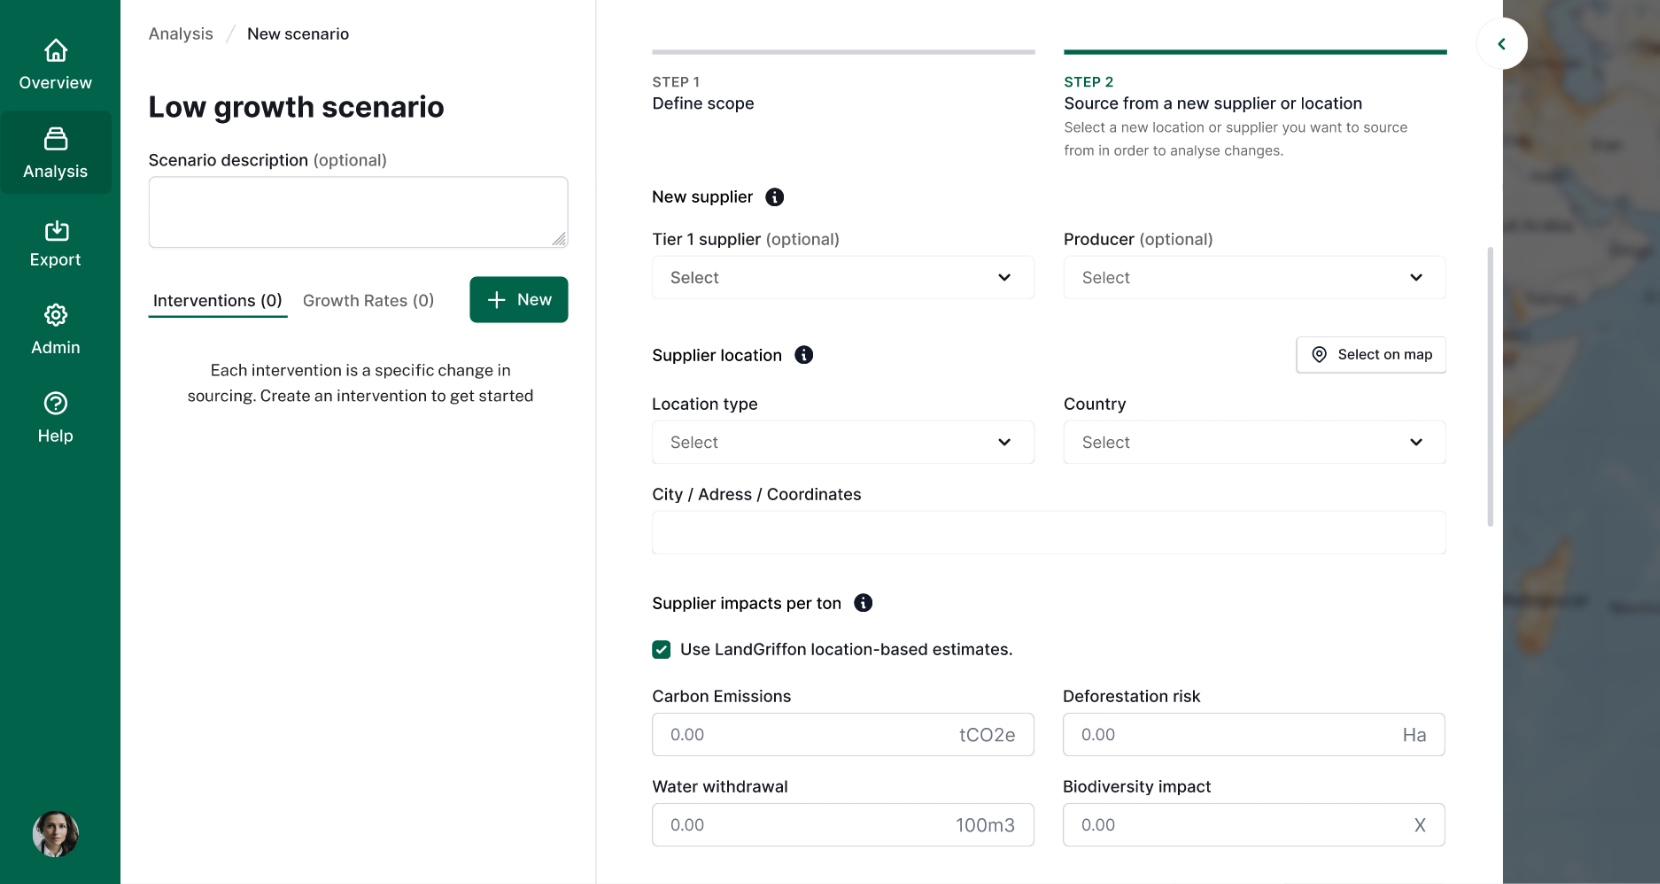

In [82]:
Image(filename="../../datasets/raw/images/change_supplier.png", width=900, height=300)

The user can select:

#### new supplier: 
 - a t1 supplier and producer that has been ingested in the ddbb (this is an optional field)
 
#### supplier location: this information should be used for geolocate the data 

 - Location type (point of production, aggregation point, country of production or unknown)
 - country: one from admin areas
 - city/address/coordin
 
 NOTE: Here we will need to add the validation develop for each location type (e.g. if point of production type selected, lat, long information should be provided)
 
#### Supplier impacts per ton: 



- use lg ones - from indicator value
- custom by the client

NOTE: THis information is also required. If selected LG location base estimates selected, the user won't we able to add custom ones. We should show the value for those LG base estimates.


Once all of this has been selected, we will need to retrive the data with these new filters:

In [83]:
# SELECT NEW PARAMS FOR INTERVENTION
new_supplier = None  # optional
new_producer = None  # optional

new_location_type = "country of production"
new_country = "ESP"
city = "Valencia"
## in this case the georegioId is 7f7316fb-db05-4215-835b-68569923aead

# select LG location base estimates

select_LG_baseEstimates = True

In [101]:
georegion_id = "7f7316fb-db05-4215-835b-68569923aead"
material_id = "0d7b1be5-dc86-47b8-ba3a-25190a275011"

estimates = get_LG_base_estimates(material_id, georegion_id)
estimates

{'c71eb531-2c8e-40d2-ae49-1049543be4d1': (2.7182616663100666e-50,),
 '633cf928-7c4f-41a3-99c5-e8c1bda0b323': (4.019240016805381e-50,),
 '0594aba7-70a5-460c-9b58-fc1802d264ea': (1.585711511223728e-49,),
 'e2c00251-fe31-4330-8c38-604535d795dc': (3.2056356568078366e-09,)}

In [117]:
## to calculate the new impact we just need to multiply the LG base estimates times the volume and project that response
# distribute volume:

user_estimates = {
    "c71eb531-2c8e-40d2-ae49-1049543be4d1": (1,),
    "633cf928-7c4f-41a3-99c5-e8c1bda0b323": (20,),
    "0594aba7-70a5-460c-9b58-fc1802d264ea": (5,),
    "e2c00251-fe31-4330-8c38-604535d795dc": (70,),
}

# calculate impacts
new_response = calculate_new_impact(estimates, clean_response)
new_response_user = calculate_new_impact(user_estimates, clean_response)

# project impacts
new_parsed_data = project_data(
    response=new_response, default_agr=1.5, groupBy="material", start_year=2019, end_year=2022
)
new_parsed_data_user = project_data(
    response=new_response_user, default_agr=1.5, groupBy="material", start_year=2019, end_year=2022
)

In [113]:
# exacmple for one location
print("indicator", parsed_data[0]["indicatorShortName"])
print("material", parsed_data[0]["rows"][0]["name"])
pd.DataFrame(parsed_data[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,3005.0,3034.5,3080.0175,3126.217762
isProjected,False,False,True,True


In [114]:
# exacmple for one location
print("indicator", new_parsed_data[0]["indicatorShortName"])
print("material", new_parsed_data[0]["rows"][0]["name"])
pd.DataFrame(new_parsed_data[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,0.0,0.0,0.0,0.0
isProjected,False,False,True,True


In [118]:
# exacmple for one location
print("indicator", new_parsed_data_user[0]["indicatorShortName"])
print("material", new_parsed_data_user[0]["rows"][0]["name"])
pd.DataFrame(new_parsed_data_user[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,7110.0,7180.0,7287.7,7397.0155
isProjected,False,False,True,True


<a id='Changetherawmaterial'></a>
### 3.2 Change the raw material

The user should be able to selec a new material and the volume of the new material they want to switch to. This would be a one to one or many to one change.

This new material can be obtained either from the same supplier or a new supplier (tier 1 supplier and producer filters are optional - if not information provided, we will assume that this new material will be sourced by the same supplier as the original one).

The user should also select the location of the new material and the if the impacts should be calculated using LG location-base estimates or some provided ones.

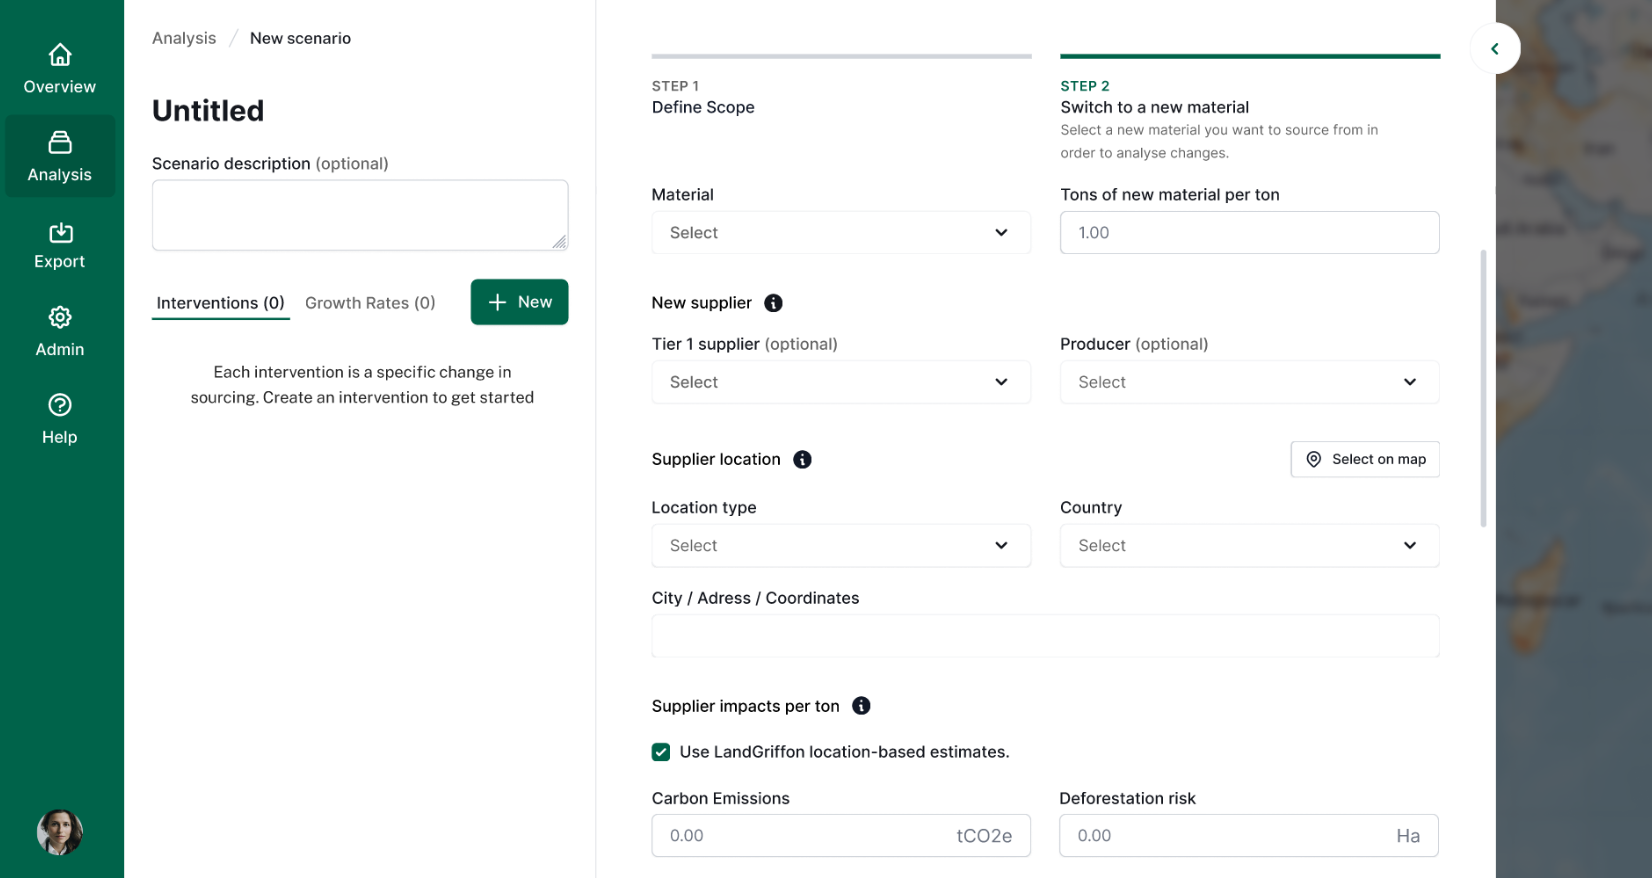

In [28]:
Image(filename="../../datasets/raw/images/Change_raw_materials.png", width=900, height=300)

In [120]:
# e.g. change cotton in a supplier from india
new_material = "80d52237-bb4a-4f25-9133-cbbebaa68734"
georegion_id = "309d7e9d-0c3b-47b3-8176-406d2ebbf61e"

estimates = get_LG_base_estimates(new_material, georegion_id)
estimates

{'c71eb531-2c8e-40d2-ae49-1049543be4d1': (3.5993184488895307e-07,),
 '633cf928-7c4f-41a3-99c5-e8c1bda0b323': (1.312561445332849e-07,),
 '0594aba7-70a5-460c-9b58-fc1802d264ea': (3.692426932191067e-07,),
 'e2c00251-fe31-4330-8c38-604535d795dc': (5.618221267543765e-10,)}

In [121]:
# calculate and project impacts:
# calculate impacts
new_response = calculate_new_impact(estimates, clean_response)

# project impacts
new_parsed_data = project_data(
    response=new_response, default_agr=1.5, groupBy="material", start_year=2019, end_year=2022
)

# exacmple for one location
print("indicator", parsed_data[0]["indicatorShortName"])
print("material", parsed_data[0]["rows"][0]["name"])
pd.DataFrame(parsed_data[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,3005.0,3034.5,3080.0175,3126.217762
isProjected,False,False,True,True


In [122]:
# exacmple for one location
print("indicator", new_parsed_data[0]["indicatorShortName"])
print("material", new_parsed_data[0]["rows"][0]["name"])
pd.DataFrame(new_parsed_data[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,0.000525,0.00053,0.000538,0.000546
isProjected,False,False,True,True


<a id='Changeefficiency'></a>
### 3.3 Change efficiency

In the generation of the intervention, the user should be able of selecting the year of completion and change in production efficiency
The user should also be able of change in production efficiency by adding new values to the original LG location-base estimates in relation to the 4 base indicators

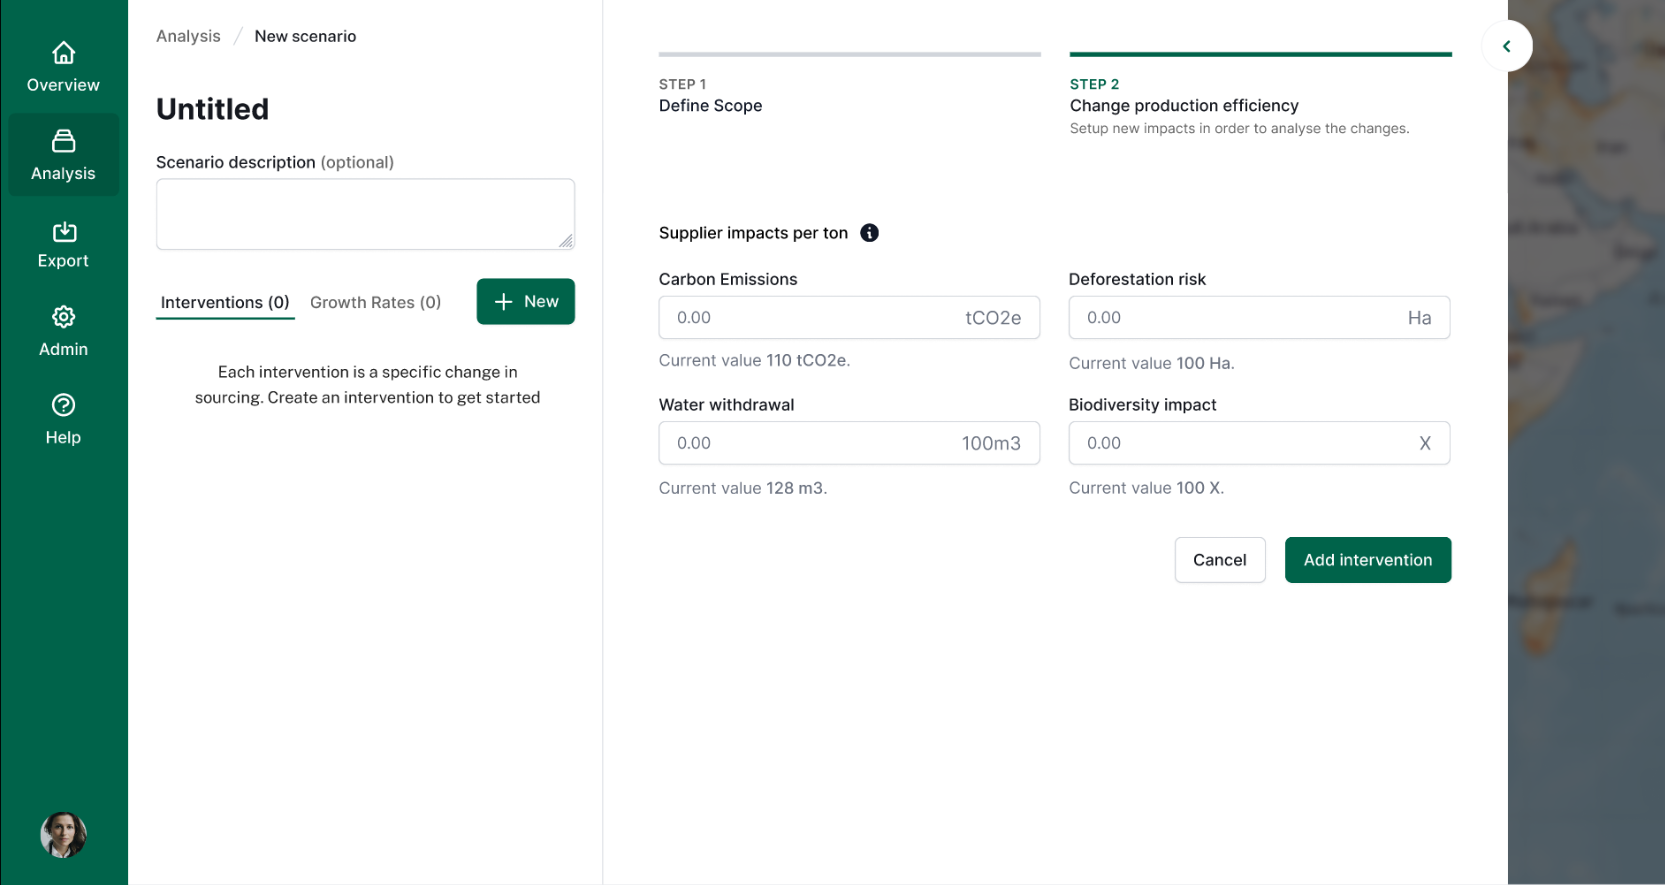

In [29]:
Image(filename="../../datasets/raw/images/change_prod_efficiency.png", width=900, height=300)

In [123]:
## to calculate the new impact we just need to multiply the LG base estimates times the volume and project that response
# distribute volume:

user_estimates = {
    "c71eb531-2c8e-40d2-ae49-1049543be4d1": (1,),
    "633cf928-7c4f-41a3-99c5-e8c1bda0b323": (20,),
    "0594aba7-70a5-460c-9b58-fc1802d264ea": (5,),
    "e2c00251-fe31-4330-8c38-604535d795dc": (70,),
}

# calculate impacts
new_response_user = calculate_new_impact(user_estimates, clean_response)

# project impacts
new_parsed_data_user = project_data(
    response=new_response_user, default_agr=1.5, groupBy="material", start_year=2019, end_year=2022
)

# exacmple for one location
print("indicator", parsed_data[0]["indicatorShortName"])
print("material", parsed_data[0]["rows"][0]["name"])
pd.DataFrame(parsed_data[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,3005.0,3034.5,3080.0175,3126.217762
isProjected,False,False,True,True


In [124]:
# exacmple for one location
print("indicator", new_parsed_data_user[0]["indicatorShortName"])
print("material", new_parsed_data_user[0]["rows"][0]["name"])
pd.DataFrame(new_parsed_data_user[0]["rows"][0]["values"]).transpose()

indicator biodiversity loss
material Rubber and articles thereof


,0,1,2,3
year,2019,2020,2021,2022
value,7110.0,7180.0,7287.7,7397.0155
isProjected,False,False,True,True


<a id='finalNotes'></a>
## 4. Final notes